In [1]:
%load_ext autoreload
%autoreload 
import os
os.chdir(os.path.dirname((os.path.dirname(os.getcwd()))))
from functools import partial
import cvxpy as cp
import numpy as np
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split
from survLime.datasets.load_datasets import RandomSurvivalData
from survLime import survlime_tabular
from survLime.scripts.experiment_1 import create_clusters
from survLime.utils.generic_utils import compare_survival_times
np.random.seed(42)

<frozen importlib._bootstrap>:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [72]:
# Create clusters can be found in scripts/experiment_1
cluster_0, cluster_1 = create_clusters()
x_train_1, x_test_2, y_train_1, y_test_1 = train_test_split(cluster_0[0],
                                                            cluster_0[1], test_size=0.1, random_state=10)
x_train_1, x_test_3, y_train_1, y_test_1 = train_test_split(cluster_1[0],
                                                            cluster_1[1], test_size=0.1, random_state=10)
#X_3 = np.concatenate([cluster_0[0], cluster_1[0]]); y_3 = np.concatenate([cluster_0[1], cluster_1[1]])  
#x_train, x_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.5)  
#x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_train, y_train, test_size=0.1, random_state=10)

times = [x[1] for x in y_train_1]
times_to_fill = list(set(times))
times_to_fill.sort() 
m = len(times_to_fill)
m

613

In [73]:
# Train bb model
columns =[f'feat_{i}' for i in range(x_train_1.shape[1])]
model = CoxPHSurvivalAnalysis(alpha=0.0001)
model.fit(x_train_1, y_train_1)
model.feature_names_in_ = columns # This is needed in order to compare survival times later

# Obtain a test point to use for prediction
test_point = x_test_1[0]
test_point_2 = x_test_1[7]

In [20]:
# Wrapper for predict function
predict_chf = partial(model.predict_cumulative_hazard_function, return_array=True)

In [21]:
# Baseline cumulative hazard 
H0 = model.cum_baseline_hazard_.y.reshape(m, 1)
len(H0)

610

In [30]:
explainer = survlime_tabular.LimeTabularExplainer(x_train_1,
                                                  y_train_1,
                                                  H0=H0)
num_neighbours = 1000
# From here we are only using log_correction, Ho_t_ and inverse 
b_0, opt_value = explainer.explain_instance(test_point,predict_chf,  verbose=False, num_samples = num_neighbours)
print(opt_value)
print('--------------------')
print(b_0.T)
print('--------------------')
print(model.coef_)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


4.591194022105651e-19
--------------------
[[-0.00665387 -0.14675983 -0.00540004  0.01771835 -0.11980289]]
--------------------
[-0.00665387 -0.14675983 -0.00540004  0.01771835 -0.11980289]


In [31]:
b_1, opt_value = explainer.explain_instance(test_point_2,predict_chf,  verbose=False, num_samples = num_neighbours)
print(opt_value)
print('--------------------')
print(b_1.T)
print('--------------------')
print(model.coef_)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


7.565760578972419e-20
--------------------
[[-0.00665387 -0.14675983 -0.00540004  0.01771835 -0.11980289]]
--------------------
[-0.00665387 -0.14675983 -0.00540004  0.01771835 -0.11980289]


In [ ]:
# Coefficient coppied from survLime/scripts/experiment_1.create_clusters
coefficients = [10**(-6), 0.1,  -0.15, 10**(-6), 10**(-6)]
values = [x[0] for x in b]
print(coefficients)
print(values)
print(model.coef_)
compare_survival_times(model, values, x_train_1, y_train_1, x_test_1, true_coef=coefficients)

# Prueba de los valores obtenidos con Experiment 1

In [77]:
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
coefficients = [10**(-6), 0.1,  -0.15, 10**(-6), 10**(-6)]
coefficients = [10**(-6), -0.15, 10**(-6), 10**(-6), -0.1]  
compt_weights= pd.read_csv('/home/carlos.hernandez/PhD/SurvLIME/exp_1.2_surv_weights_na.csv')
coef = model.coef_

dist = euclidean_distances(compt_weights, coef.reshape(1,-1))
closest = list(dist).index(min(dist))
furthest = list(dist).index(max(dist))

In [85]:
compt_weights.mean().values
np.sqrt(((compt_weights.mean() - coef) ** 2).mean())

0.04002265455081884

In [135]:
our_error = np.sqrt(np.mean(np.sum(np.square(compt_weights - coefficients), axis=1)))
from sklearn.metrics import mean_squared_error
tot_error = 0
for i in range(len(compt_weights)):
    tot_error += mean_squared_error(compt_weights.iloc[i], coefficients)
np.sqrt(tot_error)
type(coefficients)

list

In [100]:
print(compt_weights.mean().values)
print(coefficients)
print(compt_weights.mean() - coefficients)

[-0.03049272 -0.06750494 -0.02091348 -0.00567525 -0.11301488]
[1e-06, -0.15, 1e-06, 1e-06, -0.1]
one      -0.030494
two       0.082495
 three   -0.020914
four     -0.005676
five     -0.013015
dtype: float64


In [117]:
diff = coef - compt_weights.to_numpy()
rmse = np.sqrt(np.mean(diff**2))
rmse

0.05384069913194759

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


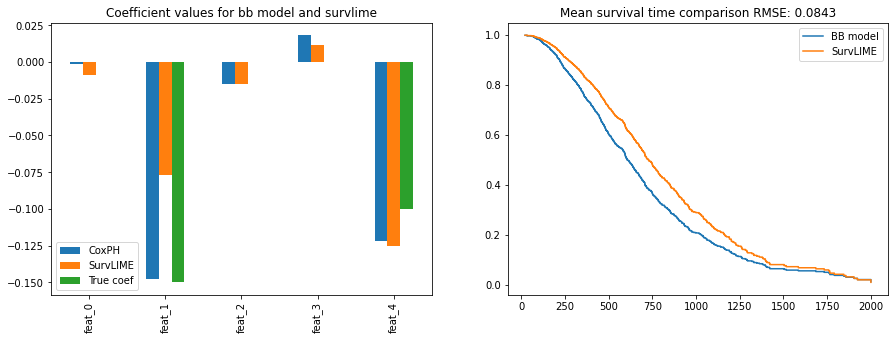

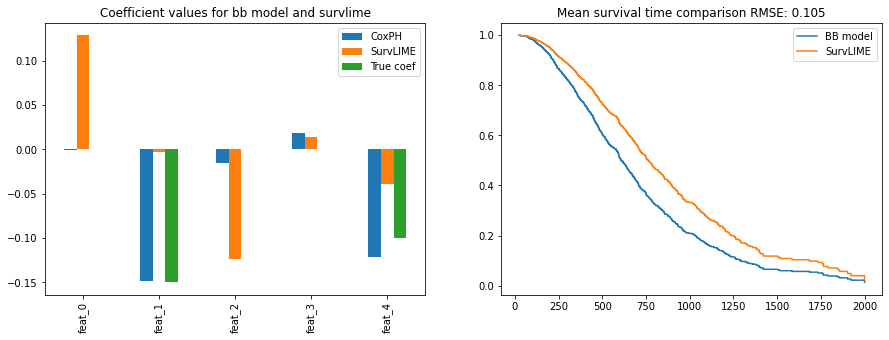

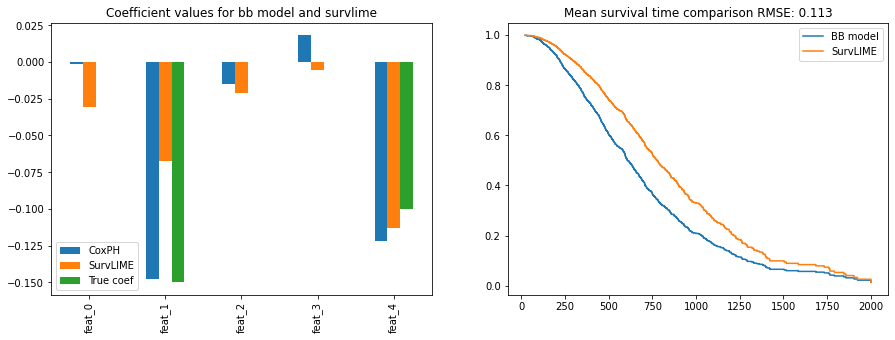

In [78]:
from survLime.utils.generic_utils import compare_survival_times,compare_cum_hazard_curves

compare_survival_times(model, compt_weights.iloc[closest], x_train_1, y_train_1, x_test_1, true_coef =coefficients)
compare_survival_times(model, compt_weights.iloc[furthest], x_train_1, y_train_1, x_test_1,true_coef =coefficients)
compare_survival_times(model, compt_weights.mean(), x_train_1, y_train_1, x_test_1, true_coef =coefficients )

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


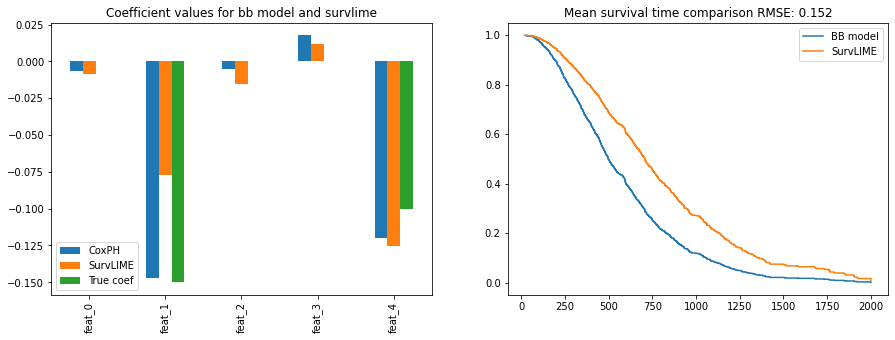

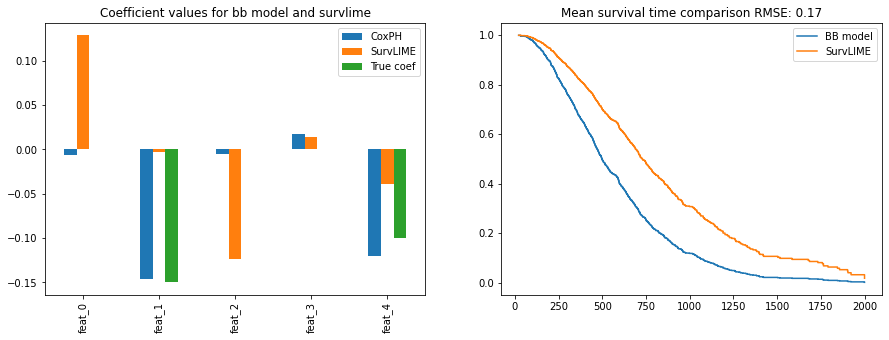

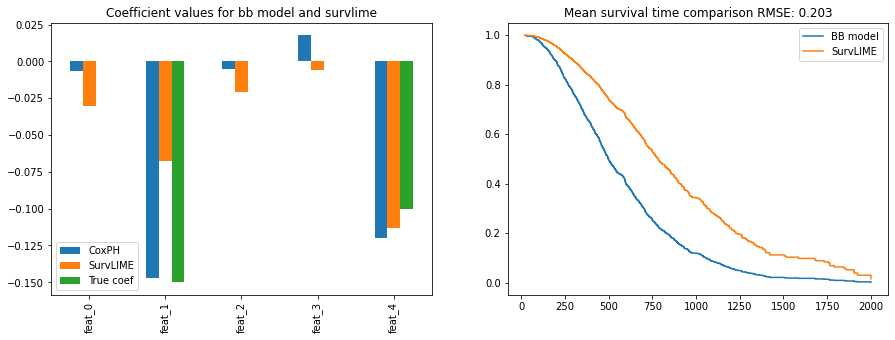

In [19]:
compare_survival_times(model, compt_weights.iloc[closest], x_train_1, y_train_1, x_test_1, true_coef =coefficients)
compare_survival_times(model, compt_weights.iloc[furthest], x_train_1, y_train_1, x_test_1,true_coef =coefficients)
compare_survival_times(model, compt_weights.mean(), x_train_1, y_train_1, x_test_1, true_coef =coefficients )